In [1]:
from config import hdf5_path, spec_minmax_scaler_path, spec_log_transformer_path
from data_loader import SpectLoader
from model import ConvNetwork
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
import librosa
import torch.nn.functional as F

In [2]:
def data_dist(pprocessor, train_keys, threshold=0.05):
    num_bins = 50
    bin_edges = np.linspace(start=0.0, stop=1.0, num=num_bins + 1)  # Adjust the range based on your data's expected value range

    bin_counts = np.zeros(num_bins)
    for x_batch, _ in pprocessor.batch_generator(train_keys):
        
        data = x_batch.numpy() if hasattr(x_batch, 'numpy') else x_batch

        flattened_data = data.flatten()

        hist, _ = np.histogram(flattened_data, bins=bin_edges)
        bin_counts += hist  

    bin_counts_cumulative = np.cumsum(bin_counts)  

    bin_counts_cumulative = bin_counts_cumulative / bin_counts_cumulative[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(bin_edges[1:], bin_counts_cumulative, color='blue', alpha=0.7, lw=2)
    plt.title("Cumulative Distribution of Values in x_batch")
    plt.xlabel("Value")
    plt.ylabel("Cumulative Frequency")
    plt.grid(True)
    plt.show()

    bin_index_percentile = np.argmax(bin_counts_cumulative >= threshold)
    bin_start = bin_edges[bin_index_percentile]
    bin_end = bin_edges[bin_index_percentile + 1]

    print(f"The bin containing 5% of the data is between {bin_start} and {bin_end}")

    return bin_edges

def plot_spect(sepct):
    plt.figure(figsize=(10, 5))  # Adjust figure size as needed
    plt.imshow(sepct, aspect='auto', cmap='hot', origin='lower')
    plt.colorbar(label='Intensity')  # Optional: Add a colorbar
    plt.title('Spectrogram Heatmap')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

def plot_several(batch, n_show):
    for i in range(n_show):
        matrix = batch[i].squeeze(0).numpy()
        plot_spect(matrix)




In [7]:
model = ConvNetwork(input_shape=(1, 256, 512))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

paths = {
        "data_path": hdf5_path,
        "scaler_path": spec_minmax_scaler_path
    }

pprocessor = SpectLoader(paths, batch_size=32)
train_keys, val_keys, test_keys = pprocessor.split_data()
#pprocessor.fit_clipper()
pprocessor.setup_pipeline(scaler_type="normalizer",load_model=True)
#print(pprocessor.pipeline)

#_ = data_dist(pprocessor, train_keys)



{'feature_range': (0, 1), 'min_': -550.0, 'scale_': 529.7587146759033}


In [8]:
count = 0
for x_batch, y_batch in pprocessor.batch_generator(train_keys):
    resized_tensor = F.interpolate(x_batch, size=(256, 512), mode='bilinear', align_corners=False, antialias=True)

    optimizer.zero_grad()    

    outputs = model(resized_tensor)
    loss = criterion(outputs, y_batch)

    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        _, train_preds = torch.max(outputs, 1)
        train_accuracy = (train_preds == y_batch).float().mean().item()
    
    count+=1
    print(f'Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}')

    if count == 5:
        break

    

Loss: 2.0804, Train Accuracy: 0.0625
Loss: 2.0339, Train Accuracy: 0.2812
Loss: 2.0016, Train Accuracy: 0.2812
Loss: 2.1297, Train Accuracy: 0.0938
Loss: 1.9615, Train Accuracy: 0.2500


weight      (64,) | mean -0.000098 | std 2.463473e-04 | grad:data ratio 1.286435e-03
weight      (64,) | mean -0.000245 | std 4.625371e-04 | grad:data ratio 1.788085e-02
weight     (128,) | mean -0.000290 | std 6.590221e-04 | grad:data ratio 2.711236e-02
weight     (128,) | mean -0.000668 | std 1.309799e-03 | grad:data ratio 8.184158e-02
weight     (256,) | mean -0.000762 | std 1.899483e-03 | grad:data ratio 1.159655e-01
weight     (256,) | mean -0.002427 | std 3.273143e-03 | grad:data ratio 2.710310e-01
weight      (64,) | mean -0.000386 | std 6.017128e-03 | grad:data ratio 7.485191e+00
weight       (8,) | mean +0.000000 | std 7.248520e-02 | grad:data ratio 1.116038e+00


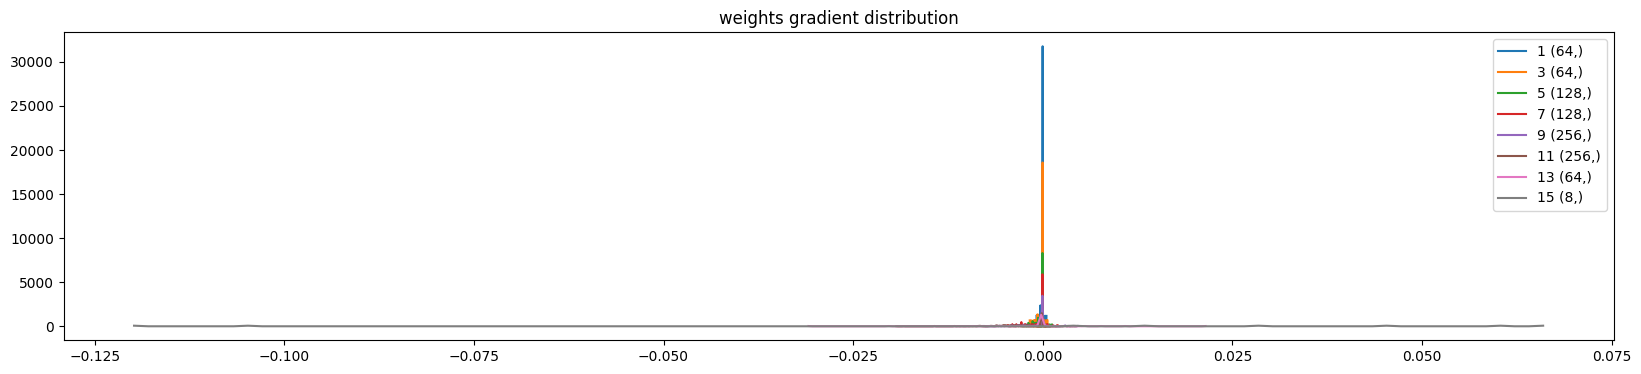

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(model.parameters()):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
